In [ ]:
# pip install -q scikit-learn litellm

In [1]:
# Import groundedness feedback function
from trulens_eval.feedback import GroundTruthAgreement, Groundedness
from trulens_eval import TruBasicApp, Feedback, Tru, LiteLLM
from test_cases import generate_ms_marco_context_relevance_benchmark
from benchmark_frameworks.eval_as_recommendation import score_passages, compute_ndcg, compute_ece, precision_at_k
Tru().reset_database()


dataset_path = "./datasets/ms_marco_train.json"
benchmark_data = list(generate_ms_marco_context_relevance_benchmark(dataset_path))


🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "..."
os.environ["HUGGINGFACE_API_KEY"] = "..."
os.environ["ANTHROPIC_API_KEY"] = "..."
os.environ["TOGETHERAI_API_KEY"] = "..."

#### Define feedback functions for contexnt relevance to be evaluated

In [3]:
from trulens_eval.feedback import OpenAI, LiteLLM

import openai
import random

# GPT 3.5
turbo = OpenAI(model_engine="gpt-3.5-turbo")

def wrapped_relevance_turbo(input, output):
    # return random value between 0 and 1
    return random.uniform(0, 1)

    # return turbo.qs_relevance(input, output)

# # GPT 4
gpt4 = OpenAI(model_engine="gpt-4")

def wrapped_relevance_gpt4(input, output):
    return random.uniform(0, 1)
#     return gpt4.qs_relevance(input, output)


# Anthropic
claude_1 = LiteLLM(model_engine="claude-instant-1")
def wrapped_relevance_claude1(input, output):
    return random.uniform(0, 1)
    # return claude_1.qs_relevance(input, output)

claude_2 = LiteLLM(model_engine="claude-2")
def wrapped_relevance_claude2(input, output):
    return random.uniform(0, 1)
    # return claude_2.qs_relevance(input, output)

# # Meta
llama_2_13b = LiteLLM(model_engine="together_ai/togethercomputer/Llama-2-7B-32K-Instruct")
def wrapped_relevance_llama2(input, output):
    return random.uniform(0, 1)
    # return llama_2_13b.qs_relevance(input, output)

In [6]:
import pandas as pd
import numpy as np
import matplotlib
df = pd.DataFrame(benchmark_data)

In [7]:
# Define a list of your feedback functions
feedback_functions = {
    'GPT-3.5-Turbo': wrapped_relevance_turbo,
    'GPT-4': wrapped_relevance_gpt4,
    'Claude-1': wrapped_relevance_claude1,
    'Claude-2': wrapped_relevance_claude2,
    'Llama-2': wrapped_relevance_llama2
}

# Running the benchmark
results = []

K = 3 # for precision@K

for name, func in feedback_functions.items():
    scores, true_relevance = score_passages(df, func)
    ndcg_value = compute_ndcg(scores, true_relevance)
    ece_value = compute_ece(scores, true_relevance)
    precision_k = np.mean([precision_at_k(sc, tr, K) for tr, sc in zip(scores, true_relevance)])

    results.append((name, ndcg_value, ece_value, precision_k))

# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=['Model', 'nDCG', f'Precision@{K}', 'ECE'])


In [8]:
results_df

,Model,nDCG,Precision@3,ECE
0,GPT-3.5-Turbo,0.560089,0.334870,0.175000
1,GPT-4,0.500738,0.355418,0.150000
2,Claude-1,0.444720,0.339366,0.100000
3,Claude-2,0.476120,0.385940,0.125000
4,Llama-2,0.455046,0.371282,0.116667


### Visualization

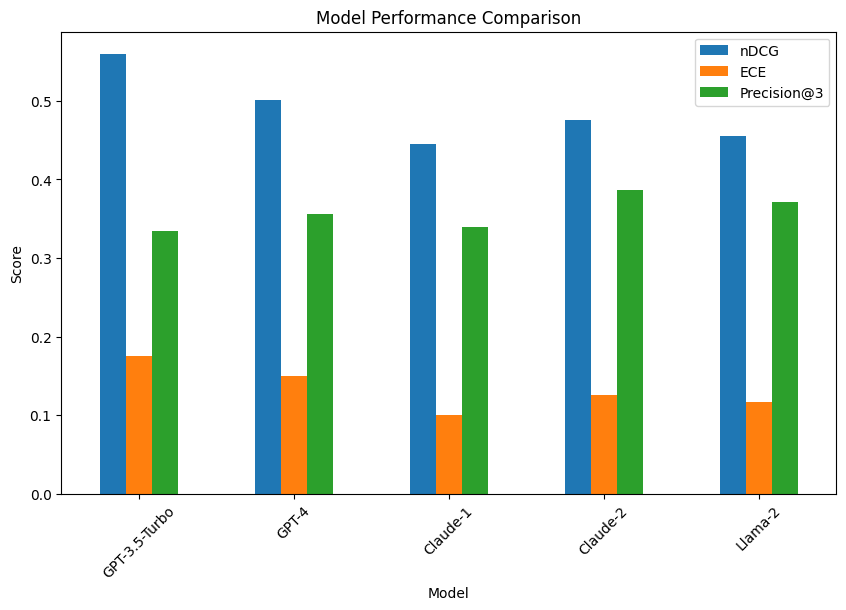

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = results_df.plot(x='Model', y=['nDCG', 'ECE', f'Precision@{K}'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


